# Single Fire Avoidance with Varying Wind

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import multivariate_normal
from scipy.integrate import solve_bvp
from scipy.integrate import cumtrapz
import matplotlib.image as mpimg

In [187]:
w1_init = 1.0
w2_init = -0.5

def get_wind(t):
    w1 = w1_init + 0.5 * np.sin(1.5 * t)
    w2 = w2_init + 0.3 * np.cos(1.8 * t)
    mag = np.hypot(w1, w2)
    w1 = np.where(mag < 0.1, w1 / mag, w1)
    w2 = np.where(mag < 0.1, w2 / mag, w2)
    return w1, w2

In [188]:
# past_wind_means = [0]
# def get_wind(t):
#     new_theta = np.random.normal(past_wind_means[-1], np.pi/128)
#     past_wind_means.append(new_theta)
#     w1 = np.cos(new_theta)
#     w2 = np.sin(new_theta)
#     return w1, w2

In [189]:
# def get_wind(t):
#     w1 = -0.25*t + 0.02 * np.sin(20 * t) + 0.5
#     w2 = 0.25*t + 0.03 * np.cos(25 * t)
#     return w1, w2

In [ ]:
fire_cost = 50_000 # Cost of fire

initial_height = 1

def fire(t, x, y, x0, y0, sigma2_0, k, c):
    """
    Fire dynamics model.
    
    Parameters:
    t (float): Time
    x (float): X-coordinate
    y (float): Y-coordinate
    x0 (float): Initial x-coordinate of fire
    y0 (float): Initial y-coordinate of fire
    sigma2_0 (float): Initial variance
    k (float): Growth rate in direction of wind
    c (float): Growth rate in direction perpendicular to wind

    Returns:
    float: Fire intensity at time t
    """
    w1, w2 = get_wind(t)
    u_x = w1 / np.sqrt(w1**2 + w2**2)
    u_y = w2 / np.sqrt(w1**2 + w2**2)

    mu_x = x0 + w1 * t
    mu_y = y0 + w2 * t
    sigma_parallel = sigma2_0 + k * t
    sigma_perp = sigma2_0 + c * t

    # Covariance matrix elements for each t
    cov_11 = u_x**2 * sigma_parallel + u_y**2 * sigma_perp
    cov_12 = u_x * u_y * (sigma_parallel - sigma_perp)
    cov_22 = u_y**2 * sigma_parallel + u_x**2 * sigma_perp 

    # Compute determinant and inverse elements
    det = cov_11 * cov_22 - cov_12**2
    if np.any(det <= 0):
        raise ValueError("Determinant of covariance matrix is non-positive.")

    inv_11 = cov_22 / det
    inv_12 = -cov_12 / det
    inv_22 = cov_11 / det

    dx = x - mu_x
    dy = y - mu_y

    # Compute exponent
    exponent = -0.5 * (inv_11 * dx**2 + 2 * inv_12 * dx * dy + inv_22 * dy**2)
    normalization = 1.0 / (2 * np.pi * np.sqrt(det))

    if isinstance(t, float):
        denom = multivariate_normal.pdf([0,0], mean=[0,0], cov=np.array([[cov_11, cov_12], [cov_12, cov_22]])) 

    else:
        n = len(t)
        denom = np.array([multivariate_normal.pdf([0,0], mean=[0,0], cov=np.array([[cov_11[i], cov_12[i]], [cov_12[i], cov_22[i]]])) for i in range(n)])
    
    height_scale = 1/denom
    return fire_cost * normalization * np.exp(exponent) * height_scale


def grad_fire(t, x, y, x0, y0, sigma2_0, k, c):
    """
    Gradient of fire intensity.
    
    Parameters:
    t (float): Time
    x (float): X-coordinate
    y (float): Y-coordinate
    x0 (float): Initial x-coordinate of fire
    y0 (float): Initial y-coordinate of fire
    sigma2_0 (float): Initial variance
    k (float): Growth rate in direction of wind
    c (float): Growth rate in direction perpendicular to wind

    Returns:
    np.ndarray: Gradient of fire intensity
    """
    w1, w2 = get_wind(t)
    u_x = w1 / np.sqrt(w1**2 + w2**2)
    u_y = w2 / np.sqrt(w1**2 + w2**2)
    
    f = fire(t, x, y, x0, y0, sigma2_0, k, c)
    
    mu_x = x0 + w1 * t
    mu_y = y0 + w2 * t
    sigma_parallel = sigma2_0 + k * t
    sigma_perp = sigma2_0 + c * t

    # Covariance matrix elements
    cov_11 = u_x**2 * sigma_parallel + u_y**2 * sigma_perp
    cov_12 = u_x * u_y * (sigma_parallel - sigma_perp)
    cov_22 = u_y**2 * sigma_parallel + u_x**2 * sigma_perp 

    # Compute inverse elements
    det = cov_11 * cov_22 - cov_12**2
    if np.any(det <= 0):
        raise ValueError("Determinant of covariance matrix is non-positive.")
    
    inv_11 = cov_22 / det
    inv_12 = -cov_12 / det
    inv_22 = cov_11 / det

    dx = x - mu_x
    dy = y - mu_y

    grad_x = -f * (inv_11 * dx + inv_12 * dy)
    grad_y = -f * (inv_12 * dx + inv_22 * dy)
    
    return grad_x, grad_y

In [191]:
# Parameters
target = np.array([15., 5.])
x0, y0 = 0., 0.
sigma_0 = 1.
k = 2
c = 1
control_penalty = 2
time_penalty = 100

s0 = np.array([-5, -2.5, 0, 0])

def fire_ode(t, z, p):
    x, y, vx, vy, p1, p2, p3, p4 = z
    tf = np.clip(p[0], 0, None)
    f_x, f_y = grad_fire(tf * t, x, y, x0, y0, sigma_0**2, k, c)

    w1, w2 = get_wind(t)
    return p[0] * np.array([
        vx,
        vy,
        0.5 * p3 / control_penalty + 2*w1,
        0.5 * p4 / control_penalty + 2*w2,
        f_x,
        f_y,
        -p1,
        -p2
    ])

def bc(ya, yb, p):
    x, y, vx, vy, p1, p2, p3, p4 = yb
    u1, u2 = 0.5 * p3 / control_penalty, 0.5 * p4 / control_penalty
    tf = np.clip(p[0], 0, None)
    H = p1*vx + p2*vy + p3*u1 + p4*u2 - (time_penalty * p[0] + fire(tf, x, y, x0, y0, sigma_0**2, k, c) + control_penalty * (u1**2 + u2**2) / 2)
    return np.array([
        ya[0] - s0[0],
        ya[1] - s0[1],
        ya[2] - s0[2],
        ya[3] - s0[3],
        yb[0] - target[0],
        yb[1] - target[1],
        yb[2],
        yb[3],
        H
    ])

# Initial mesh and guess
t_steps = 500
t = np.linspace(0, 1, t_steps)
z0 = np.zeros((8, t_steps))
z0[0, :] = np.linspace(s0[0], target[0], t_steps)
z0[1, :] = np.linspace(s0[1], target[1], t_steps)
p0 = np.array([1.0])
v_guess = (target - s0[:2]) / p0[0]
z0[2, :] = v_guess[0]
z0[3, :] = v_guess[1]

# Solve BVP
sol = solve_bvp(fire_ode, bc, t, z0, p0, tol=1e-2, max_nodes=1_000_00)

if not sol.success:
    print("BVP solver failed:", sol.message)

TypeError: object of type 'numpy.float64' has no len()

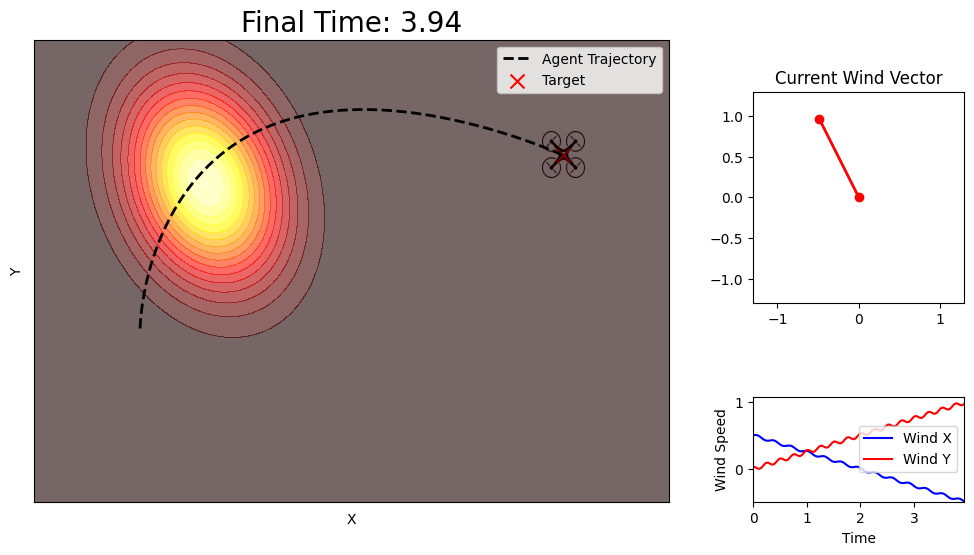

In [ ]:
np.seterr(invalid='ignore')

# Fire and wind parameters
x0, y0 = 0, 0
sigma0 = 1
k, c = 2, 1
w1_init, w2_init = 1.0, -0.5

# # Wind function with minimum magnitude
# def get_wind(t):
#     w1 = w1_init + 0.5 * np.sin(1.5 * t)
#     w2 = w2_init + 0.3 * np.cos(1.8 * t)
#     mag = np.hypot(w1, w2)
#     if mag < 0.1:
#         return w1 / mag * 0.1, w2 / mag * 0.1
#     else:
#         return w1, w2

# Extract agent trajectory and timing from your solution
tf = sol.p[0]
t_eval = np.linspace(0, tf, len(sol.y[0]))
x_traj = sol.y[0]
y_traj = sol.y[1]

t_values = np.linspace(0, tf, 100)

w1_list, w2_list = zip(*[get_wind(t) for t in t_values])

# Mesh for fire density
x, y = np.linspace(-10, 20, 100), np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)

# Set up figure and layout
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[3, 1])

# Main fire + trajectory plot
main_ax = fig.add_subplot(gs[:, 0])
main_ax.set_xlim(-10, 20)
main_ax.set_ylim(-10, 10)
main_ax.set_xlabel('X')
main_ax.set_ylabel('Y')
main_ax.set_title(f'Final Time: {tf:.2f}', fontsize=20)

# Wind vector subplot
vector_ax = fig.add_subplot(gs[0, 1])
max_wind = max(np.hypot(w1, w2) for w1, w2 in zip(w1_list, w2_list)) * 1.2
vector_ax.set(xlim=(-max_wind, max_wind), ylim=(-max_wind, max_wind),
              aspect='equal', title='Current Wind Vector')

# Wind evolution subplot
wind_ax = fig.add_subplot(gs[1, 1])
wind_ax.set(xlim=(0, tf), 
            ylim=(min(min(w1_list), min(w2_list)), max(max(w1_list), max(w2_list)) * 1.1),
            xlabel='Time', ylabel='Wind Speed')
wind_line1, = wind_ax.plot([], [], 'b-', label='Wind X')
wind_line2, = wind_ax.plot([], [], 'r-', label='Wind Y')
wind_ax.legend()

# Initialize dynamic elements
contour = None
traj_line, = main_ax.plot([], [], 'k--', lw=2, label='Agent Trajectory')
main_ax.legend()
drone_img = mpimg.imread('images/drone2.png')
drone_size = 1.0
drone = main_ax.imshow(drone_img, aspect='auto', extent=[-100, -99, -100, -99])

# Static target
main_ax.scatter(target[0], target[1], marker='x', color='red', s=100, label='Target')
main_ax.legend()

main_ax.set_title(f"Final Time: {tf:.2f}", fontsize=20)
main_ax.set_xticks([])
main_ax.set_yticks([])

def update(i):
    global contour
    t_anim = t_values[i]
    w1, w2 = w1_list[i], w2_list[i]

    # Fire center movement 
    mean_x = x0 + (w1 * t_anim)
    mean_y = y0 + (w2* t_anim )

    # Wind direction unit vector
    wind_mag = np.hypot(w1, w2)
    u_x, u_y = (w1 / wind_mag, w2 / wind_mag) if wind_mag > 0 else (1, 0)

    # Time-dependent variances
    sigma_parallel = sigma0**2 + k * t_anim
    sigma_perp = sigma0**2 + c * t_anim

    # Covariance matrix
    cov_11 = u_x**2 * sigma_parallel + u_y**2 * sigma_perp
    cov_12 = u_x * u_y * (sigma_parallel - sigma_perp)
    cov_22 = u_y**2 * sigma_parallel + u_x**2 * sigma_perp
    Sigma = np.array([[cov_11, cov_12], [cov_12, cov_22]])

    # Manual Gaussian PDF computation
    det = np.linalg.det(Sigma)
    if det <= 0:
        Sigma += 1e-6 * np.eye(2)
        det = np.linalg.det(Sigma)
    inv_Sigma = np.linalg.inv(Sigma)

    dx, dy = X - mean_x, Y - mean_y
    exponent = -0.5 * (inv_Sigma[0, 0] * dx**2 + 2 * inv_Sigma[0, 1] * dx * dy + inv_Sigma[1, 1] * dy**2)
    Z = np.exp(exponent) / (2 * np.pi * np.sqrt(det))

    # Remove old contour
    if contour:
        for coll in contour.collections:
            coll.remove()
    contour = main_ax.contourf(X, Y, Z, levels=20, cmap='hot', alpha=0.6)

    # Update trajectory
    mask = t_eval <= t_anim
    traj_line.set_data(x_traj[mask], y_traj[mask])
    if mask.any():
        x_curr, y_curr = x_traj[mask][-1], y_traj[mask][-1]
        drone.set_extent([x_curr - drone_size, x_curr + drone_size, 
                          y_curr - drone_size, y_curr + drone_size])

    # Wind vector arrow (line from origin)
    vector_ax.clear()
    vector_ax.set(xlim=(-max_wind, max_wind), ylim=(-max_wind, max_wind),
                  aspect='equal', title='Current Wind Vector')
    color = 'blue' if w1 >= 0 else 'red'
    vector_ax.plot([0, w1], [0, w2], color=color, linewidth=2, marker='o')

    # Update wind over time plot
    wind_line1.set_data(t_values[:i+1], w1_list[:i+1])
    wind_line2.set_data(t_values[:i+1], w2_list[:i+1])

    return [*contour.collections, traj_line, wind_line1, wind_line2]

# Animate
ani = animation.FuncAnimation(
    fig, update, frames=len(t_values),
    interval=50, blit=False, repeat=True
)

ani.save('animations/fire1_scaled_fire.mp4', writer='ffmpeg', fps=20)
plt.show()

In [ ]:
frame_indices = [50, 70, 99]
output_filenames = ['fire1_drone_varyw_early.png', 'fire1_drone_varyw_mid.png', 'fire1_drone_varyw_end.png']

for idx, frame in zip(frame_indices, output_filenames):
    update(idx)
    fig.savefig(frame, bbox_inches='tight', dpi=800)